In [1]:
import numpy as np
import os
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from main import *
from helper import read_csv, create_csv, prepare_dataframe
import seaborn as sns
import pylab
from sklearn.metrics import mean_squared_error
from sklearn.cluster import FeatureAgglomeration
from sklearn.model_selection import train_test_split
from sklearn.random_projection import GaussianRandomProjection

# Helper Functions

These functions train a model on your data and use cross validation to determine the average negative mean squared error. You do not have to edit these! However, it might make sense to add new helper functions here.

In [2]:
def scoreLinear(X, y):
    """Trains a linear regression model and evaluates it with 3-fold cross validation.
  
    Parameters: 
    X (array): Training data of shape (n_samples, n_features)
    y (array): Target values of shape (n_samples,)
  
    Returns: 
    Float: average score of the model after cross validation
    """
    regr = linear_model.LinearRegression()
    scores = cross_val_score(regr, X, y, cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

In [3]:
def scoreBoosting(X, y):
    """Trains a gradient boosting model and evaluates it with 3-fold cross validation.
  
    Parameters: 
    X (array): Training data of shape (n_samples, n_features)
    y (array): Target values of shape (n_samples,)
  
    Returns: 
    Float: average score of the model after cross validation
    """
    clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0, loss='ls')
    scores = cross_val_score(clf, X, np.ravel(y), cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

In [4]:
def dataframeToXy(df, predict_column, feature_columns):
    """Convert the dataframe to a format usable for the ML algorithms"""
    X = df[feature_columns].values.reshape(-1, df[feature_columns].shape[1]) # all features
    y = df[[predict_column]].values.reshape(-1, 1) # values to predict
    return X, y

In [5]:
def runScoring(df, predict_column, feature_columns):
    """This runs both algorithms to determine the scores for all given features in the dataset.
    
    Parameters: 
    df (dataframe): dataframe with Score and features
    predict_column: name of the value to predict, e.g. 'Score'
    feature_columns: list of all column names that are to be used as features
  
    Returns: 
    linear: negative mean squared error of linear regression
    boost: negative mean squared error of boosting algorithm
    """
    X, y = dataframeToXy(df, predict_column, feature_columns)
    boost = scoreBoosting(X, y)
    linear = scoreLinear(X, y)
    return linear, boost

In [6]:
def runScoringSimple(df, predict_column):
    """Alternative to function above, this takes all the columns in the 
    dataframe as features except the single column which is used for the score.
    """
    all_feature_columns = list(df.columns)
    all_feature_columns.remove(predict_column)
    return runScoring(df, predict_column, all_feature_columns)

In [7]:
def createBaselineRandom(df, predict_column):
    """creates random features and returns the average score after 20 rounds"""
    np.random.seed(0)
    baseline = df[['Score']].copy()
    averageLinearScore = 0
    averageBoostingScore = 0
    rounds = 20
    for i in range(rounds):
        baseline['feature1'] = np.random.randint(0, 100, df.shape[0])
        baseline['feature2'] = np.random.randint(0, 100, df.shape[0])
        baseline['feature3'] = np.random.randint(0, 100, df.shape[0])
        lin, boost = runScoring(baseline, predict_column, ['feature1', 'feature2', 'feature3'])
        averageLinearScore += lin / rounds
        averageBoostingScore += boost / rounds
    print(f'linear   : {averageLinearScore}')
    print(f'boosting : {averageBoostingScore}')

In [8]:
def impute(data, variable):
    df = data.copy()
    median = df[variable].median()
    df[variable] = df[variable].replace(0, median)
    return df[variable]

In [9]:
def plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    df[variable].hist(bins=50)
    plt.subplot(1,2,2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    plt.tight_layout()

    if not os.path.exists('plots'):
        os.makedirs('plots')

    plt.savefig(f'plots/{variable}.png')
    plt.close()

# Load Data

Recommended: Make sure you have a column named 'Score', preferably as the first column, while the name of the municipality is the index.


In [10]:
ranking = read_csv('data', 'safety-ranking.csv')
ranking = ranking.rename(columns={'Gemeinde': 'Gemeindename'})
ranking = ranking.set_index('Gemeindename')
ranking

C:\Users\Fabio\Documents\6. Semester\dawr\dawr_assignment2_fabioryser\src\main.py:134: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.replace('---', pd.np.nan, inplace=True)


,Score,Total Anzahl Personen Sozialhilfe,Total Verunfallte Personen,Total Anzahl Unfälle 2021
Gemeindename,,,,
Doppleschwand,0.000000,0.0,0.0,0.0
Honau,0.089783,0.0,1.0,1.0
Romoos,0.161609,0.0,3.0,0.0
Flühli,0.215479,7.0,1.0,1.0
Vitznau,0.233435,9.0,0.0,2.0
...,...,...,...,...
Horw,10.055665,351.0,29.0,61.0
Ebikon,15.550368,443.0,69.0,108.0
Kriens,27.024600,1004.0,73.0,141.0


These are the features that were used to create the original ranking in Assignment 1:  
**TODO: Please write down your original features here!**


- Total Anzahl Personen Sozialhilfe
- Total Verunfallte Personen
- Total Anzahl Unfälle

# Get a first baseline for your model with random values

In [11]:
# This code creates a baseline for your model, using random features
createBaselineRandom(ranking, 'Score')

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and 

linear   : -174.09733300234578
boosting : -267.36629876029264


**WARNING**: This uses the same dataframe for both the linear model and the boosting model. In your code you will want to use different ones for the different models. Your goal is to get both of these scores to as close as 0 as possible and most likely you will need to do different steps for linear regression and for gradient boosting and therefore have different features. 

# Get a second baseline by using all features you have

In [12]:
# this assumes we have a dataframe with a column named Score and all other columns are features.
# You might have to change this code if your dataframe looks different.

prepare_dataframe(ranking)
df_final = read_csv('data', 'engineering_final.csv')
df_final = df_final.set_index('Gemeindename')
df_final = df_final.drop(columns=['Total Anzahl Dossiers'])
df_final = df_final.drop(columns=['Total Sozialhilfequote'])
df_final = df_final.drop(columns=['Total Sozialhilfequote Schweizer'])
df_final = df_final.drop(columns=['Total Sozialhilfequote Ausländer'])
df_final = df_final.drop(columns=['Durchschnitt Anzahl 2017-2021'])
df_final = df_final.drop(columns=['Rank'])
df_final = df_final.drop(columns=['überiges Eigentkapital'])

df_boosting = df_final.copy()

linear, boost = runScoringSimple(df_final, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

df_final

C:\Users\Fabio\Documents\6. Semester\dawr\dawr_assignment2_fabioryser\src\main.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df_coordinates['Ortschaftsname'] = df_coordinates['Ortschaftsname'].str.replace(' b. Willisau', '')
C:\Users\Fabio\Documents\6. Semester\dawr\dawr_assignment2_fabioryser\src\main.py:134: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.replace('---', pd.np.nan, inplace=True)
C:\Users\Fabio\Documents\6. Semester\dawr\dawr_assignment2_fabioryser\src\main.py:134: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.replace('---', pd.np.nan, inplace=True)
C:\Users\Fabio\Documents\6. Semester\dawr\dawr_assignment2_fabioryser\src\main.py:134: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future versi

linear   : -136.91771000135304
boosting : -69.54490401350662


,Score,Alter 0-17,Alter 18-64,Alter 65+,obligatorische Schule,sekundarstufe I,tertiärstufe,Personenschaden absolut mit Personenschaden,Personenschaden pro 1000 Einwohner,davon getötete Personen,...,Total Passiven,Fremdkapital,Eigenkapital,Spezielfinanzierung EK,Fond im EK,Aufwertungsreserven,Bilanzüberschuss,Anzahl Einwohner,Total Fläcke km2,Anzahl Wohngebäude
Gemeindename,,,,,,,,,,,,,,,,,,,,,
Adligenswil,1.203089,1.2,0.9,0.2,0.0,0.2,0.0,3,0.5,0,...,76818669,43315758,33502911,6979702,299028,0,26224182,1746.0,39.30,588
Aesch,0.520740,0.5,1.2,0.0,0.0,0.0,0.0,1,0.8,0,...,21466150,7704460,13761690,8167324,0,2860,5591506,1827.0,108.17,1191
Alberswil,0.700305,2.6,1.3,0.0,0.0,0.0,0.0,4,6.0,0,...,8323012,4375329,3947683,1287875,30763,0,2629044,639.0,37.39,223
Altbüron,0.718262,6.1,2.0,0.0,0.0,0.0,0.0,1,1.0,0,...,12044450,8502752,3541699,1254746,38801,0,2248152,1725.0,40.31,517
Altishofen,1.005567,2.1,1.3,0.0,0.0,0.0,0.0,5,2.5,0,...,27343168,6820858,20522311,4876009,56841,4775488,10813973,1263.0,37.76,361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Honau,0.089783,0.0,0.0,0.0,0.0,0.0,0.0,1,2.4,0,...,5414822,2694182,2720640,1765375,163816,0,791449,14739.0,12.86,2145
Rain,1.490393,0.0,0.0,0.0,0.0,0.0,0.0,12,4.1,0,...,51272154,35526066,15746088,4744277,28687,2159032,8814092,28613.0,27.30,3312
Romoos,0.161609,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,...,7584044,1241493,6342551,579826,204486,1365246,4192993,10382.0,5.83,1314


# Do your own feature engineering here

Your goal is to find the right features to get both scores as close to 0 as possible. Add more columns to your dataframe and choose which ones of those you will use for the machine learning models. Use the methods discussed in class to improve your results even further.

# add new features to dataframe

In [13]:
df_final['Einwohner pro Wohngebäude'] = df_final['Anzahl Einwohner'] / df_final['Anzahl Wohngebäude']
df_final['Durchschnittliches Einkommen pro Kopf'] = df_final['Median Einkommen'] / df_final['Anzahl Einwohner']
df_final['Fläche pro Wohngebäude'] = df_final['Total Fläcke km2'] / df_final['Anzahl Wohngebäude']

# Feature Transformation for slected features
Für die Columns in columns_to_process wurden jeweils 4 Transformationen durchgeführt. Mit der "plots" funktion kann die Column visualisiert werden. Es blieben jeweils nur die Features im dataframe, welche am nähesten an einer linearen Verteilung sind. Diese wurden dann für die weiteren Schritte verwendet.

In [14]:
columns_to_process = ['Anzahl Einwohner', 'Total Fläcke km2', 'Distanz zu nächsten Prontoshop in km', 'Anzahl Wohngebäude', 'Eigenkapital', 'Fremdkapital', 'Longitude', 'Latitude', 'Einkommen aus Vermögenserträgen', 'Frei verfügbares Einkommen', '20000','100000','1000000']

for col in columns_to_process:

    df_final[col] = impute(df_boosting, col)

    df_final[col+'_log'] = np.log(df_final[col])
    df_final[col+'_sqrt'] = df_final[col]**(1/2)
    df_final[col+'_reciprocal'] = 1 / df_final[col]
    df_final[col+'_exp'] = df_final[col]**(1/1.2)

In [15]:
df_tmp = df_final.loc[:,['Anzahl Einwohner_log','Total Fläcke km2_log','Distanz zu nächsten Prontoshop in km_sqrt','Anzahl Wohngebäude_log','Eigenkapital_log','Fremdkapital_log','Longitude','Latitude_reciprocal','Einkommen aus Vermögenserträgen_sqrt','Frei verfügbares Einkommen_reciprocal','100000_sqrt','1000000','20000_reciprocal']]

"""for column in df_tmp:
    plots(df_tmp, column)"""

df_tmp2 = df_final.iloc[:,:-52]
df_final = pd.concat([df_tmp2, df_tmp], axis=1)
df_final

,Score,Alter 0-17,Alter 18-64,Alter 65+,obligatorische Schule,sekundarstufe I,tertiärstufe,Personenschaden absolut mit Personenschaden,Personenschaden pro 1000 Einwohner,davon getötete Personen,...,Anzahl Wohngebäude_log,Eigenkapital_log,Fremdkapital_log,Longitude,Latitude_reciprocal,Einkommen aus Vermögenserträgen_sqrt,Frei verfügbares Einkommen_reciprocal,100000_sqrt,1000000,20000_reciprocal
Gemeindename,,,,,,,,,,,,,,,,,,,,,
Adligenswil,1.203089,1.2,0.9,0.2,0.0,0.2,0.0,3,0.5,0,...,6.376727,17.327143,17.584027,8.365,0.021245,2.607681,0.000026,3.652487,19.415039,0.686009
Aesch,0.520740,0.5,1.2,0.0,0.0,0.0,0.0,1,0.8,0,...,7.082549,16.437399,15.857310,8.239,0.021162,1.224745,0.000028,3.639725,19.279131,0.690012
Alberswil,0.700305,2.6,1.3,0.0,0.0,0.0,0.0,4,6.0,0,...,5.407172,15.188639,15.291492,7.997,0.021209,0.547723,0.000030,3.704235,19.971023,0.670107
Altbüron,0.718262,6.1,2.0,0.0,0.0,0.0,0.0,1,1.0,0,...,6.248043,15.080117,15.955900,7.882,0.021195,1.581139,0.000029,3.878288,20.207640,0.620261
Altishofen,1.005567,2.1,1.3,0.0,0.0,0.0,0.0,5,2.5,0,...,5.888878,16.837023,15.735496,7.960,0.021186,0.707107,0.000031,3.559820,18.438977,0.715832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Honau,0.089783,0.0,0.0,0.0,0.0,0.0,0.0,1,2.4,0,...,7.670895,14.816378,14.806605,8.406,0.021217,2.213594,0.000023,3.564570,18.488398,0.714260
Rain,1.490393,0.0,0.0,0.0,0.0,0.0,0.0,12,4.1,0,...,8.105308,16.572103,17.385777,8.263,0.021218,1.788854,0.000025,3.611725,18.982606,0.698910
Romoos,0.161609,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,...,7.180831,15.662792,14.031825,8.024,0.021272,0.894427,0.000041,3.798947,20.207640,0.642312


## es wurden nur die Plots im Verzeichnis src/plots gespeichert, welche am ehesten eine lineare Verteilung aufweisen.

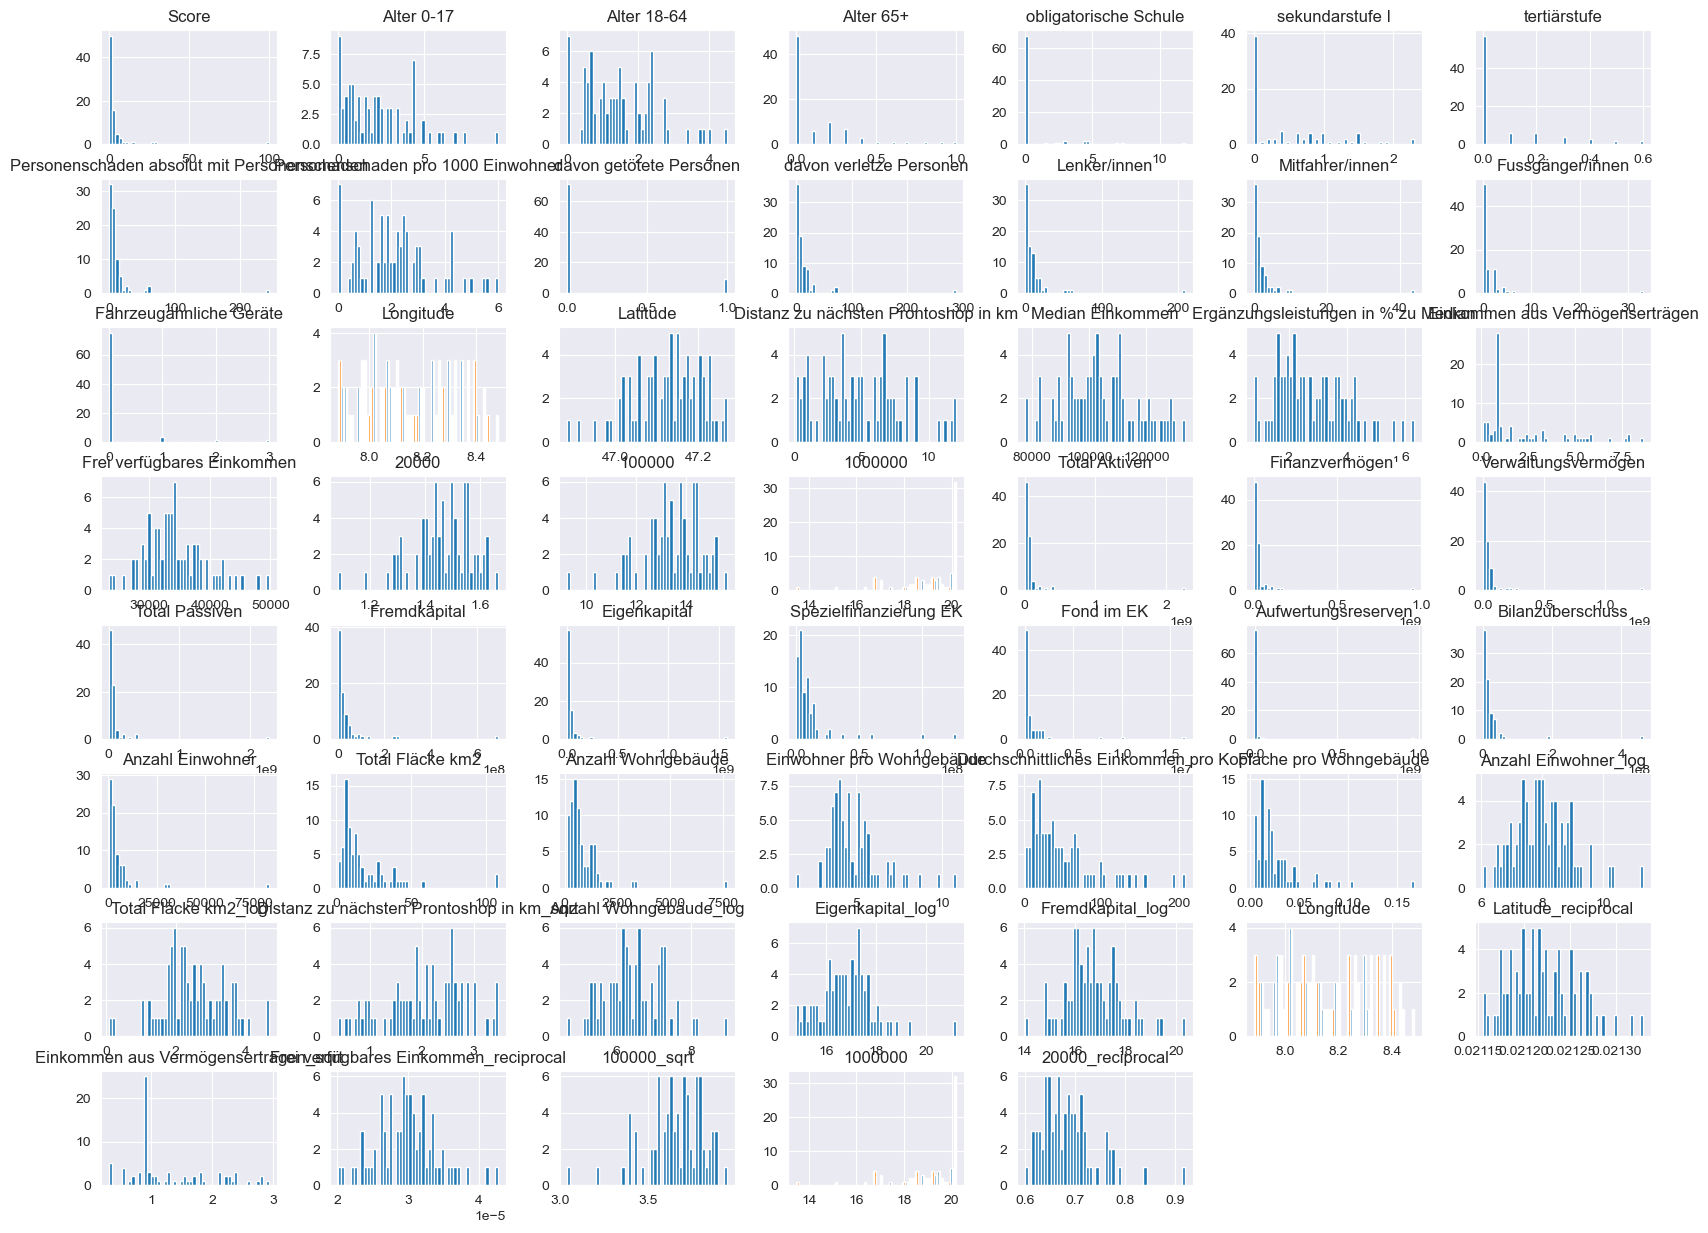

In [16]:
df_final.hist(bins=50, figsize=(20,15))
plt.show()

Distanz zu nächsten Prontoshop in km_sqrt     -0.339969
Median Einkommen                              -0.298818
Distanz zu nächsten Prontoshop in km          -0.288036
Frei verfügbares Einkommen                    -0.212563
Einkommen aus Vermögenserträgen               -0.162062
Einkommen aus Vermögenserträgen_sqrt          -0.159064
Latitude                                      -0.158034
100000                                        -0.120581
20000                                         -0.120581
100000_sqrt                                   -0.115129
1000000                                       -0.091229
1000000                                       -0.091229
Einwohner pro Wohngebäude                     -0.090359
Anzahl Einwohner                              -0.064435
Anzahl Wohngebäude                            -0.056806
Durchschnittliches Einkommen pro Kopf         -0.055907
Anzahl Einwohner_log                          -0.041493
Anzahl Wohngebäude_log                        -0

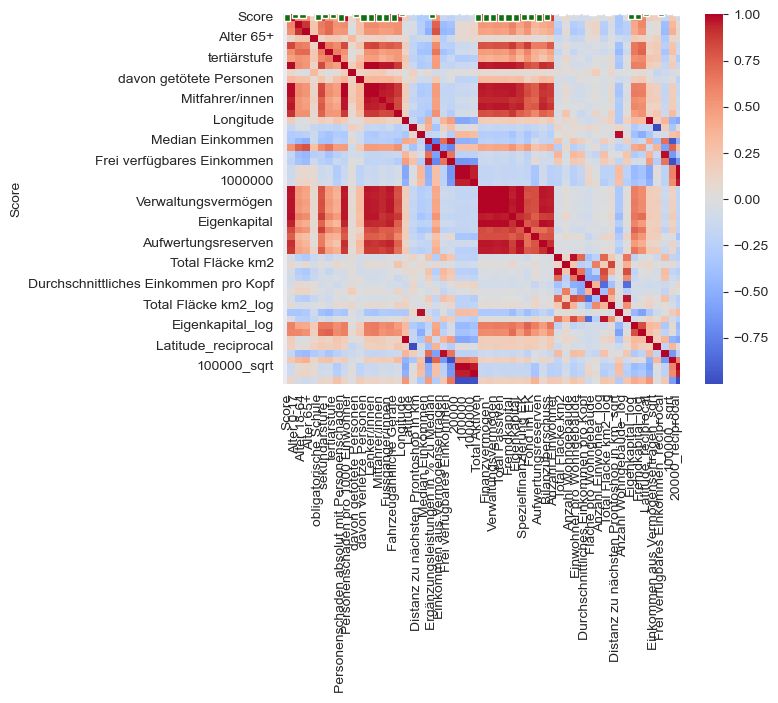

In [17]:
# Korrelationsanalyse
corr_matrix = df_final.corr(method='pearson')
sns.heatmap(corr_matrix, cmap='coolwarm')
sns.barplot(x=corr_matrix.columns, y=corr_matrix.loc['Score',:], color='g')
corr_matrix.loc['Score',:].sort_values()

# Erste Features ausschliessen
Es wurden erste Features ausgeschlossen die eine geringe Korrelation mit Score aufweisen und daher keine Einfluss auf das Resultat haben.

In [18]:
df_final = df_final.drop(columns=['Longitude', 'Personenschaden pro 1000 Einwohner', 'Alter 65+', 'Total Fläcke km2', 'Fläche pro Wohngebäude', 'Latitude', 'Einkommen aus Vermögenserträgen', '100000', '1000000', '20000'])

linear, boost = runScoringSimple(df_final, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

linear   : -61.603737883336116
boosting : -72.46659640886686


C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


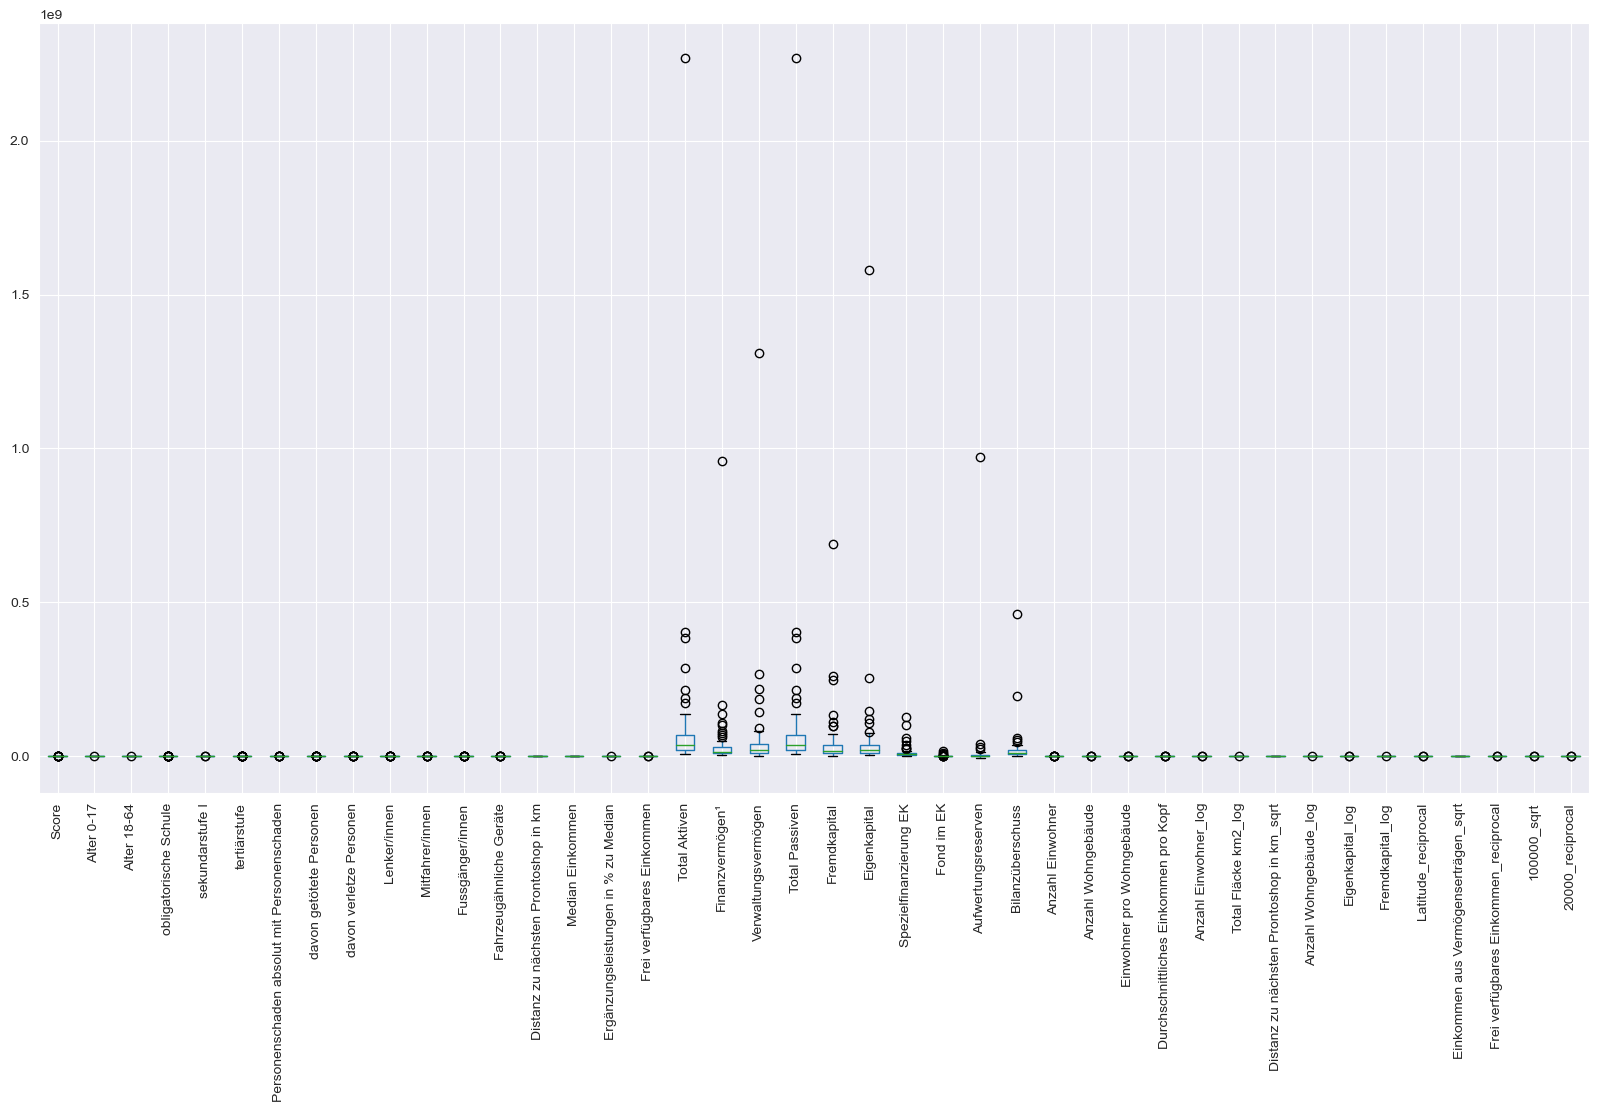

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
df_final.boxplot(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

plt.show()

# Outlier removal (using clip) bleibt auskommentiert da es zu einer Verschlechterung der Scores führt.

In [20]:
"""for column in df_final.columns:
    if column != df_final.columns[0]:
        lower = df_final[column].quantile(0.25)
        upper = df_final[column].quantile(0.75)
        df_final[column] = df_final[column].clip(lower=lower, upper=upper)

df_final"""

'for column in df_final.columns:\n    if column != df_final.columns[0]:\n        lower = df_final[column].quantile(0.25)\n        upper = df_final[column].quantile(0.75)\n        df_final[column] = df_final[column].clip(lower=lower, upper=upper)\n\ndf_final'

Dieser Schritt führte zu einer Verschlechterung, deshalb weglassen!

# Feature Normalization
Anhand der Boxplots wurden die Ausreiser ersichtlich. Normalisierung sämtlich Spalten inklusive Zielvariable führt zu einem Nahezu perfekt Score.

In [21]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df_final)
df = pd.DataFrame(scaled_data, columns=df_final.columns)
linear, boost = runScoringSimple(df, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

linear   : -0.006442814092371047
boosting : -0.007452360917030263


C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


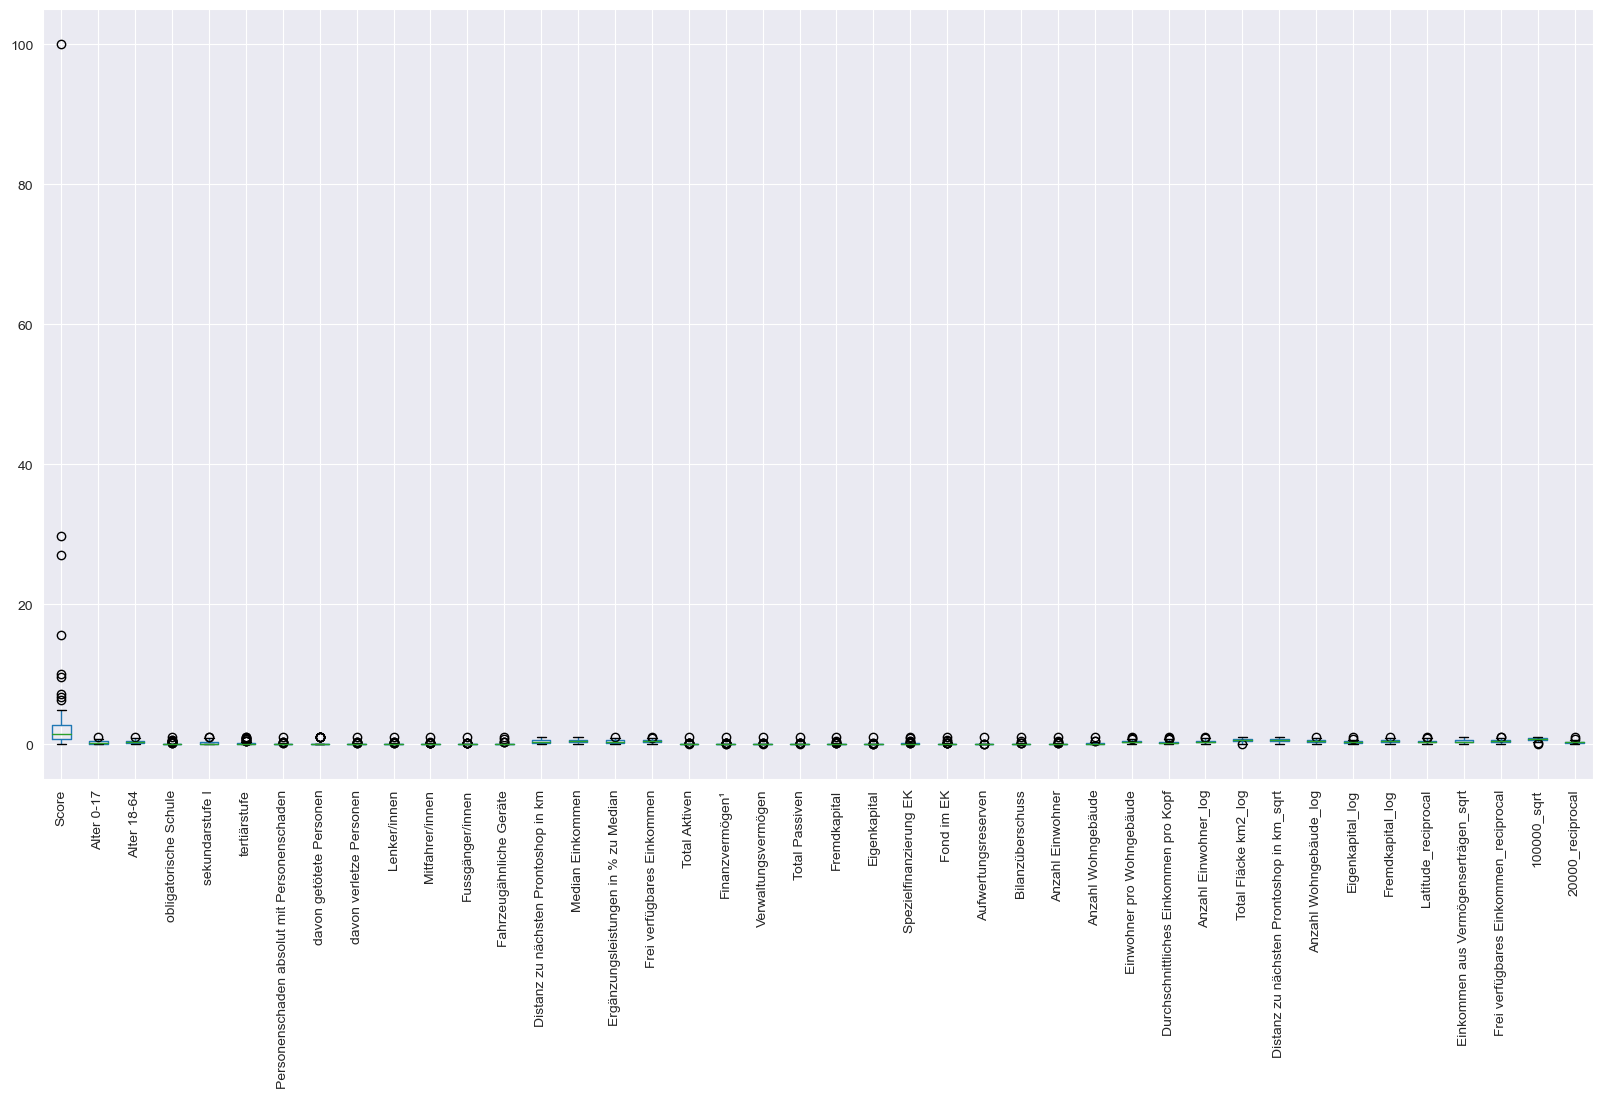

linear   : -64.42814185197419
boosting : -72.48072257387014


C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [22]:
features_to_transform = df_final.iloc[:, 1:].columns.tolist()
scaler = MinMaxScaler()
df_final[features_to_transform] = scaler.fit_transform(df_final[features_to_transform])

fig, ax = plt.subplots(figsize=(20, 10))
df_final.boxplot(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

plt.show()

linear, boost = runScoringSimple(df_final, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

# Feature Selection

In [23]:
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=7)

X = df_final.drop('Score', axis=1)
y = df_final['Score']
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
linear_score, boosting_score = runScoringSimple(df_final[selected_features.union(['Score'])], 'Score')

print(f"Selected features: {list(selected_features)}")
print(f"Linear score: {linear_score}")

Selected features: ['Total Aktiven', 'Finanzvermögen¹', 'Verwaltungsvermögen', 'Total Passiven', 'Fremdkapital', 'Eigenkapital', 'Aufwertungsreserven']
Linear score: -14.159784371900088


C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


Bestes Score erreicht mit:
- Total Aktiven
- Finanzvermögen
- Verwaltungsvermögen
- total Passiven
- Fremdkapital
- Eigenkapital
- Aufwertungsreserven

In [24]:
estimator = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0, loss='ls')
rfe = RFE(estimator, n_features_to_select=3)

X = df_final.drop('Score', axis=1)
y = df_final['Score']
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
boosting_score = scoreBoosting(df_final[selected_features.union(['Score'])].values, df_final['Score'].values)

print(f"Selected features: {list(selected_features)}")
print(f"Boosting score: {boosting_score}")

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and 

Selected features: ['Lenker/innen', 'Fussgänger/innen', 'Fremdkapital']
Boosting score: -61.413988616941275


Bestes Score erreicht mit:
- Lenker/innen
- Fusgänger/innen
- Fremdkapital

# Random Projection

In [25]:
X = df_final.iloc[:, 1:].values
rp = GaussianRandomProjection(n_components=3)
X_rp = rp.fit_transform(X)
df_final['RP 1'] = X_rp[:, 0]
df_final['RP 2'] = X_rp[:, 1]
df_final['RP 3'] = X_rp[:, 2]

linear, boost = runScoringSimple(df_final, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

df_final

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


linear   : -65.52634766439671
boosting : -74.21750349377461


,Score,Alter 0-17,Alter 18-64,obligatorische Schule,sekundarstufe I,tertiärstufe,Personenschaden absolut mit Personenschaden,davon getötete Personen,davon verletze Personen,Lenker/innen,...,Eigenkapital_log,Fremdkapital_log,Latitude_reciprocal,Einkommen aus Vermögenserträgen_sqrt,Frei verfügbares Einkommen_reciprocal,100000_sqrt,20000_reciprocal,RP 1,RP 2,RP 3
Gemeindename,,,,,,,,,,,,,,,,,,,,,
Adligenswil,1.203089,0.129032,0.200000,0.0,0.086957,0.0,0.012295,0.0,0.010417,0.014354,...,0.394559,0.561960,0.513588,0.875821,0.264722,0.671201,0.266379,1.630093,0.960123,-0.510972
Aesch,0.520740,0.053763,0.266667,0.0,0.000000,0.0,0.004098,0.0,0.013889,0.014354,...,0.254738,0.288792,0.036173,0.347246,0.335728,0.657180,0.278890,0.369543,1.397590,-0.881438
Alberswil,0.700305,0.279570,0.288889,0.0,0.000000,0.0,0.016393,0.0,0.013889,0.019139,...,0.058500,0.199280,0.308154,0.088480,0.442902,0.728055,0.216676,0.703478,0.343908,-0.413651
Altbüron,0.718262,0.655914,0.444444,0.0,0.000000,0.0,0.004098,0.0,0.003472,0.004785,...,0.041446,0.304389,0.230322,0.483464,0.395817,0.919280,0.060884,0.988240,0.936784,-0.511960
Altishofen,1.005567,0.225806,0.288889,0.0,0.000000,0.0,0.020492,0.0,0.017361,0.019139,...,0.317538,0.269521,0.173307,0.149399,0.466042,0.569391,0.359591,0.613222,0.612931,0.022896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Honau,0.089783,0.000000,0.000000,0.0,0.000000,0.0,0.004098,0.0,0.003472,0.004785,...,0.000000,0.122570,0.352303,0.725197,0.107044,0.574610,0.354677,0.935885,0.205801,-0.453118
Rain,1.490393,0.000000,0.000000,0.0,0.000000,0.0,0.049180,0.0,0.059028,0.052632,...,0.275907,0.530597,0.360097,0.562856,0.234113,0.626418,0.306699,0.912435,0.617100,-0.448239
Romoos,0.161609,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.133011,0.000000,0.670074,0.220995,0.938693,0.832111,0.129805,0.791068,1.617090,-1.260776


In [26]:
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=5)

X = df_final.drop('Score', axis=1)
y = df_final['Score']
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
linear_score, boosting_score = runScoringSimple(df_final[selected_features.union(['Score'])], 'Score')

print(f"Selected features: {list(selected_features)}")
print(f"Linear score: {linear_score}")

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


Selected features: ['Total Aktiven', 'Finanzvermögen¹', 'Verwaltungsvermögen', 'Total Passiven', 'Eigenkapital']
Linear score: -24.691746673583964


C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [27]:
estimator = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0, loss='ls')
rfe = RFE(estimator, n_features_to_select=4)

X = df_final.drop('Score', axis=1)
y = df_final['Score']
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
boosting_score = scoreBoosting(df_final[selected_features.union(['Score'])].values, df_final['Score'].values)

print(f"Selected features: {list(selected_features)}")
print(f"Boosting score: {boosting_score}")

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and 

Selected features: ['obligatorische Schule', 'Lenker/innen', 'Fussgänger/innen', 'Fremdkapital']
Boosting score: -62.52812808609992


Score konnte mit Random Projection nicht verbessert werden.

# Feature Agglomeration

In [28]:
X = df_final.iloc[:, :-1].values
y = df_final.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

agglo = FeatureAgglomeration(n_clusters=8)
X_train_agglo = agglo.fit_transform(X_train)
X_test_agglo = agglo.transform(X_test)

feature_names = list(df_final.columns[:-1])
group_names = ['Gruppe ' + str(i) for i in range(1, agglo.n_clusters+1)]
grouped_features = [list(np.array(feature_names)[agglo.labels_ == i]) for i in range(agglo.n_clusters)]
for i, group_name in enumerate(group_names):
    print(f"{group_name}: {grouped_features[i]}")

lr = LinearRegression()
lr.fit(X_train_agglo, y_train)
y_pred = lr.predict(X_test_agglo)
mse = mean_squared_error(y_test, y_pred)

linear, boost = runScoringSimple(df_final, 'Score')
print(f"Modellleistung linear ohne Feature Agglomeration: {linear}")
print(f"Modellleistung boost ohne Feature Agglomeration: {boost}")
print(f"Modellleistung mit Feature Agglomeration: {mse}")

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


Gruppe 1: ['Median Einkommen', 'Frei verfügbares Einkommen', 'Einwohner pro Wohngebäude', 'Anzahl Einwohner_log', 'Total Fläcke km2_log', 'Anzahl Wohngebäude_log', 'Einkommen aus Vermögenserträgen_sqrt']
Gruppe 2: ['obligatorische Schule', 'Personenschaden absolut mit Personenschaden', 'davon getötete Personen', 'davon verletze Personen', 'Lenker/innen', 'Mitfahrer/innen', 'Fussgänger/innen', 'Fahrzeugähnliche Geräte', 'Total Aktiven', 'Finanzvermögen¹', 'Verwaltungsvermögen', 'Total Passiven', 'Fremdkapital', 'Eigenkapital', 'Spezielfinanzierung EK', 'Fond im EK', 'Aufwertungsreserven', 'Bilanzüberschuss', 'Anzahl Einwohner', 'Anzahl Wohngebäude']
Gruppe 3: ['Ergänzungsleistungen in % zu Median', 'Durchschnittliches Einkommen pro Kopf', 'Eigenkapital_log', 'Fremdkapital_log', 'Latitude_reciprocal', 'Frei verfügbares Einkommen_reciprocal', '20000_reciprocal']
Gruppe 4: ['Alter 0-17', 'Alter 18-64', 'sekundarstufe I', 'tertiärstufe']
Gruppe 5: ['RP 1']
Gruppe 6: ['RP 2']
Gruppe 7: ['Dis

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


Modellleistung linear ohne Feature Agglomeration: -65.52634766439671
Modellleistung boost ohne Feature Agglomeration: -74.21750349377461
Modellleistung mit Feature Agglomeration: 0.12910163852997641
